In [1]:
import pandas as pd
import numpy as np
import os
import pickle
import time
import timeit
import json

os.environ["DGLBACKEND"] = "pytorch"

from dgl import from_networkx
import networkx as nx


import torch as th
import torch.nn as nn
import torch.nn.functional as F

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, classification_report

import matplotlib.pyplot as plt
import itertools

from src.models import EGRAPHSAGE, EGAT, EGCN
from src.dataset.dataset_info import datasets
from src.graph.graph_measures import calculate_graph_measures

# datasets = {dataset.name: dataset for dataset in datasets_list}

num_epochs = 100
batch_size = 128
learning_rate = 0.001
LAMBD_1 = 0.0001
LAMBD_2 = 0.001


In [2]:
# name = "cic_ids_2017_5_percent"
# name = "cic_ton_iot_5_percent"
# name = "cic_ton_iot"
name = "cic_ids_2017"
# name = "nf_bot_iot"
# name = "edge_iiot"
# name = "nf_cse_cic_ids2018"
# name = "nf_bot_iotv2"
# name = "nf_uq_nids"
# name = "x_iiot"
# name = "cic_ton_iot_modified"
# name = "nf_ton_iotv2_modified"
# name = "ccd_inid_modified"
# name = "nf_uq_nids_modified"

dataset = datasets[name]

In [3]:
results_final = {}

results_final["name"] = name
results_final["configuration"] = {
    "num_epochs": num_epochs,
    "batch_size": batch_size,
    # "early_stopping": early_stopping,
    # "pca": pca,
    # "digraph_centralities": digraph_centralities,
    # "multi_graph_centralities": multi_graph_centralities,
    # "learning_rate": learning_rate,
    # "LAMBD_1": LAMBD_1,
    # "LAMBD_2": LAMBD_2,
    # "cfg": OmegaConf.to_container(cfg)
}

results_final["accuracy"] = {}
results_final["time_elapsed"] = {}

    
results_final["e_gcn"] = {}
results_final["e_gcn_res"] = {}

results_final["e_graph_sage"] = {}
results_final["e_graph_sage_res"] = {}

results_final["e_gat"] = {}
results_final["e_gat_res"] = {}


results_final

{'name': 'cic_ids_2017',
 'configuration': {'num_epochs': 100, 'batch_size': 128},
 'accuracy': {},
 'e_gcn': {},
 'e_gcn_res': {},
 'e_graph_sage': {},
 'e_graph_sage_res': {},
 'e_gat': {},
 'e_gat_res': {}}

In [4]:
dtime = time.strftime("%Y%m%d-%H%M%S")
dtime

'20240922-204702'

In [5]:
results_folder_path = "results"
if not os.path.isdir(results_folder_path):
    os.mkdir(results_folder_path)

results_folder_path1 = os.path.join(results_folder_path, name)
if not os.path.isdir(results_folder_path1):
    os.mkdir(results_folder_path1)

folder_path = os.path.join(results_folder_path1, dtime)
if not os.path.isdir(folder_path):
    os.mkdir(folder_path)
    
confusion_matrices_path = os.path.join(folder_path, "confusion_matrices")
if not os.path.isdir(confusion_matrices_path):
    os.mkdir(confusion_matrices_path)

In [6]:
with open("datasets/" + name + "/training_graph.pkl", "rb") as f:
    G = pickle.load(f)

In [7]:
G = from_networkx(G,edge_attrs=['h',dataset.label_col] )

In [8]:
num_features = G.edata['h'].shape[1]
num_features

32

In [9]:
G.ndata['h'] = th.ones(G.num_nodes(), num_features)

G.ndata['h'] = th.reshape(G.ndata['h'], (G.ndata['h'].shape[0], 1, num_features))
G.edata['h'] = th.reshape(G.edata['h'], (G.edata['h'].shape[0], 1, num_features))

G.edata['train_mask'] = th.ones(len(G.edata['h']), dtype=th.bool)

In [10]:
from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight('balanced',
                                                 classes = np.unique(G.edata[dataset.label_col].cpu().numpy()),
                                                 y = G.edata[dataset.label_col].cpu().numpy())

In [11]:
class_weights = th.FloatTensor(class_weights)

criterion = nn.CrossEntropyLoss(weight = class_weights)

In [12]:
def compute_accuracy(pred, labels):
    return (pred.argmax(1) == labels).float().mean().item()

In [13]:
def train_gnn(model_class, Graph, residual, num_neighbors = None):
    node_features = Graph.ndata['h']
    edge_features = Graph.edata['h']

    edge_label = Graph.edata[dataset.label_col]
    train_mask = Graph.edata['train_mask']

    # model = EGRAPHSAGE(num_features, num_features, 128, F.relu,
    #                    dropout=0.2, num_neighbors=4, residual=residual)

    if num_neighbors:
        model = model_class(num_features, num_features, 128, F.relu,
                    dropout=0.2, num_neighbors=num_neighbors, residual=residual)
    else:
        model = model_class(num_features, num_features, 128, F.relu,
                    dropout=0.2, residual=residual)

    opt = th.optim.Adam(model.parameters())

    for epoch in range(1,num_epochs):
    #     pred = model(G, node_features,edge_features).cuda()
        pred = model(Graph, node_features,edge_features)
        loss = criterion(pred[train_mask] ,edge_label[train_mask])
        opt.zero_grad()
        loss.backward()
        opt.step()
        print('Epoch:', epoch ,' Training acc:', compute_accuracy(pred[train_mask], edge_label[train_mask]))

    return model

### Training EGCN

In [14]:
model_gcn = train_gnn(EGCN, G, False, None)

Epoch: 1  Training acc: 0.6816907525062561
Epoch: 2  Training acc: 0.9729889035224915
Epoch: 3  Training acc: 0.9730381369590759
Epoch: 4  Training acc: 0.9704458117485046
Epoch: 5  Training acc: 0.9902345538139343
Epoch: 6  Training acc: 0.9969087839126587
Epoch: 7  Training acc: 0.9974979758262634
Epoch: 8  Training acc: 0.9953492283821106
Epoch: 9  Training acc: 0.9977192878723145
Epoch: 10  Training acc: 0.9978116154670715
Epoch: 11  Training acc: 0.9978557825088501
Epoch: 12  Training acc: 0.9978659152984619
Epoch: 13  Training acc: 0.9978709816932678
Epoch: 14  Training acc: 0.9978775978088379
Epoch: 15  Training acc: 0.997895359992981
Epoch: 16  Training acc: 0.9979110956192017
Epoch: 17  Training acc: 0.9978689551353455
Epoch: 18  Training acc: 0.9979339241981506
Epoch: 19  Training acc: 0.9979318976402283
Epoch: 20  Training acc: 0.9978801608085632
Epoch: 21  Training acc: 0.9979181885719299
Epoch: 22  Training acc: 0.9979288578033447
Epoch: 23  Training acc: 0.997917175292968

### Training EGCN residual

In [15]:
model_gcn_res = train_gnn(EGCN, G, True, None)

Epoch: 1  Training acc: 0.4447263479232788
Epoch: 2  Training acc: 0.7207074165344238
Epoch: 3  Training acc: 0.7529985904693604
Epoch: 4  Training acc: 0.8178139328956604
Epoch: 5  Training acc: 0.8981452584266663
Epoch: 6  Training acc: 0.9470243453979492
Epoch: 7  Training acc: 0.9791921973228455
Epoch: 8  Training acc: 0.9934003949165344
Epoch: 9  Training acc: 0.9961018562316895
Epoch: 10  Training acc: 0.9968453049659729
Epoch: 11  Training acc: 0.9972954988479614
Epoch: 12  Training acc: 0.9976015090942383
Epoch: 13  Training acc: 0.9976893067359924
Epoch: 14  Training acc: 0.9976816773414612
Epoch: 15  Training acc: 0.9977415800094604
Epoch: 16  Training acc: 0.9977481961250305
Epoch: 17  Training acc: 0.9977943897247314
Epoch: 18  Training acc: 0.9978415966033936
Epoch: 19  Training acc: 0.9978329539299011
Epoch: 20  Training acc: 0.9978705048561096
Epoch: 21  Training acc: 0.9978857040405273
Epoch: 22  Training acc: 0.9978709816932678
Epoch: 23  Training acc: 0.99788928031921

### Training EGraphSage 

In [16]:
model_sage = train_gnn(EGRAPHSAGE, G, False, 4)

Epoch: 1  Training acc: 0.004744180478155613
Epoch: 2  Training acc: 0.5972216725349426
Epoch: 3  Training acc: 0.8834640979766846
Epoch: 4  Training acc: 0.950993537902832
Epoch: 5  Training acc: 0.9268067479133606
Epoch: 6  Training acc: 0.9692460298538208
Epoch: 7  Training acc: 0.9715572595596313
Epoch: 8  Training acc: 0.9830208420753479
Epoch: 9  Training acc: 0.9918875098228455
Epoch: 10  Training acc: 0.9962591528892517
Epoch: 11  Training acc: 0.9934008717536926
Epoch: 12  Training acc: 0.9880623817443848
Epoch: 13  Training acc: 0.9877477288246155
Epoch: 14  Training acc: 0.9978486895561218
Epoch: 15  Training acc: 0.997072160243988
Epoch: 16  Training acc: 0.9957029223442078
Epoch: 17  Training acc: 0.9979096055030823
Epoch: 18  Training acc: 0.9979288578033447
Epoch: 19  Training acc: 0.9991545081138611
Epoch: 20  Training acc: 0.997901976108551
Epoch: 21  Training acc: 0.9933156371116638
Epoch: 22  Training acc: 0.9977405667304993
Epoch: 23  Training acc: 0.804708063602447

### Training EGraphSage residual

In [17]:
model_sage_res = train_gnn(EGRAPHSAGE, G, True, 4)

Epoch: 1  Training acc: 0.13682910799980164
Epoch: 2  Training acc: 0.24434813857078552
Epoch: 3  Training acc: 0.4069165289402008
Epoch: 4  Training acc: 0.513674795627594
Epoch: 5  Training acc: 0.7438644766807556
Epoch: 6  Training acc: 0.7946573495864868
Epoch: 7  Training acc: 0.8794223070144653
Epoch: 8  Training acc: 0.9680204391479492
Epoch: 9  Training acc: 0.9777234792709351
Epoch: 10  Training acc: 0.993548572063446
Epoch: 11  Training acc: 0.9941149353981018
Epoch: 12  Training acc: 0.9973695874214172
Epoch: 13  Training acc: 0.9957267642021179
Epoch: 14  Training acc: 0.9952903389930725
Epoch: 15  Training acc: 0.9893149137496948
Epoch: 16  Training acc: 0.9915672540664673
Epoch: 17  Training acc: 0.9952675104141235
Epoch: 18  Training acc: 0.9899432063102722
Epoch: 19  Training acc: 0.9977385401725769
Epoch: 20  Training acc: 0.9927746057510376
Epoch: 21  Training acc: 0.9990748167037964
Epoch: 22  Training acc: 0.999055027961731
Epoch: 23  Training acc: 0.997898399829864

### Training EGAT

In [18]:
model_gat = train_gnn(EGAT, G, False, None)

Epoch: 1  Training acc: 0.29643821716308594
Epoch: 2  Training acc: 0.8748542070388794
Epoch: 3  Training acc: 0.9958460330963135
Epoch: 4  Training acc: 0.9892286658287048
Epoch: 5  Training acc: 0.9893326759338379
Epoch: 6  Training acc: 0.9903675317764282
Epoch: 7  Training acc: 0.9942860007286072
Epoch: 8  Training acc: 0.9978750944137573
Epoch: 9  Training acc: 0.9979212284088135
Epoch: 10  Training acc: 0.9979283809661865
Epoch: 11  Training acc: 0.9980136156082153
Epoch: 12  Training acc: 0.9980176687240601
Epoch: 13  Training acc: 0.9980186820030212
Epoch: 14  Training acc: 0.9980212450027466
Epoch: 15  Training acc: 0.9980207085609436
Epoch: 16  Training acc: 0.9980212450027466
Epoch: 17  Training acc: 0.9980176687240601
Epoch: 18  Training acc: 0.9979806542396545
Epoch: 19  Training acc: 0.9979618787765503
Epoch: 20  Training acc: 0.9979466199874878
Epoch: 21  Training acc: 0.9979466199874878
Epoch: 22  Training acc: 0.9979618787765503
Epoch: 23  Training acc: 0.9979664087295

### Training EGAT residual

In [19]:
model_gat_res = train_gnn(EGAT, G, True, None)

Epoch: 1  Training acc: 0.3263319134712219
Epoch: 2  Training acc: 0.47013115882873535
Epoch: 3  Training acc: 0.6061553359031677
Epoch: 4  Training acc: 0.9039744734764099
Epoch: 5  Training acc: 0.9640273451805115
Epoch: 6  Training acc: 0.9823813438415527
Epoch: 7  Training acc: 0.987496018409729
Epoch: 8  Training acc: 0.9897559881210327
Epoch: 9  Training acc: 0.9928553104400635
Epoch: 10  Training acc: 0.997467041015625
Epoch: 11  Training acc: 0.9979004263877869
Epoch: 12  Training acc: 0.9979907870292664
Epoch: 13  Training acc: 0.9980136156082153
Epoch: 14  Training acc: 0.9980176687240601
Epoch: 15  Training acc: 0.9980196952819824
Epoch: 16  Training acc: 0.9980207085609436
Epoch: 17  Training acc: 0.9980196952819824
Epoch: 18  Training acc: 0.9980242848396301
Epoch: 19  Training acc: 0.9980247616767883
Epoch: 20  Training acc: 0.9980252981185913
Epoch: 21  Training acc: 0.9980257749557495
Epoch: 22  Training acc: 0.9980252981185913
Epoch: 23  Training acc: 0.998025298118591

# Testing

In [20]:
with open("datasets/" + name + "/testing_graph.pkl", "rb") as f:
    G_test = pickle.load(f)

In [21]:
G_test = from_networkx(G_test,edge_attrs=['h',dataset.label_col] )

In [22]:
actual_label = G_test.edata.pop(dataset.label_col)
G_test.ndata['feature'] = th.ones(G_test.num_nodes(),num_features)

In [23]:
G_test.ndata['feature'] = th.reshape(G_test.ndata['feature'], (G_test.ndata['feature'].shape[0], 1, G_test.ndata['feature'].shape[1]))
G_test.edata['h'] = th.reshape(G_test.edata['h'], (G_test.edata['h'].shape[0], 1, G_test.edata['h'].shape[1]))

In [57]:
def test_gnn(model, graph):
    start_time = timeit.default_timer()
    node_features_test = graph.ndata['feature']
    edge_features_test = graph.edata['h']
    # test_pred = model(G_test, node_features_test, edge_features_test).cuda()
    test_pred = model(graph, node_features_test, edge_features_test)
    elapsed = timeit.default_timer() - start_time
    print(str(elapsed) + ' seconds')

    test_pred = test_pred.argmax(1)
    test_pred = th.Tensor.cpu(test_pred).detach().numpy()

    actual = ["Normal" if i == 0 else "Attack" for i in actual_label]
    test_pred = ["Normal" if i == 0 else "Attack" for i in test_pred]

    return (actual, test_pred, elapsed)


In [58]:

def calculate_FPR_FNR(cm):
 
    TN = cm[0][0]
    FN = cm[1][0]
    TP = cm[1][1]
    FP = cm[0][1]
 
    # Sensitivity, hit rate, recall, or true positive rate
    TPR = TP/(TP+FN)
    # Specificity or true negative rate
    TNR = TN/(TN+FP)
    # Precision or positive predictive value
    PPV = TP/(TP+FP)
    # Negative predictive value
    NPV = TN/(TN+FN)
    # Fall out or false positive rate
    FPR = FP/(FP+TN)
    # False negative rate
    FNR = FN/(TP+FN)
    # False discovery rate
    FDR = FP/(TP+FP)
 
    return FPR, FNR

In [59]:
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True,
                          file_path = None):
    

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(12, 12))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    if file_path:
        plt.savefig(file_path)
    plt.show()

### Testing EGCN

In [60]:
actual, test_pred, elapsed = test_gnn(model_gcn, G_test)

1.9541786015033722 seconds


In [61]:
labels = ["Normal", "Attack"]
cm = confusion_matrix(actual, test_pred, labels= labels)

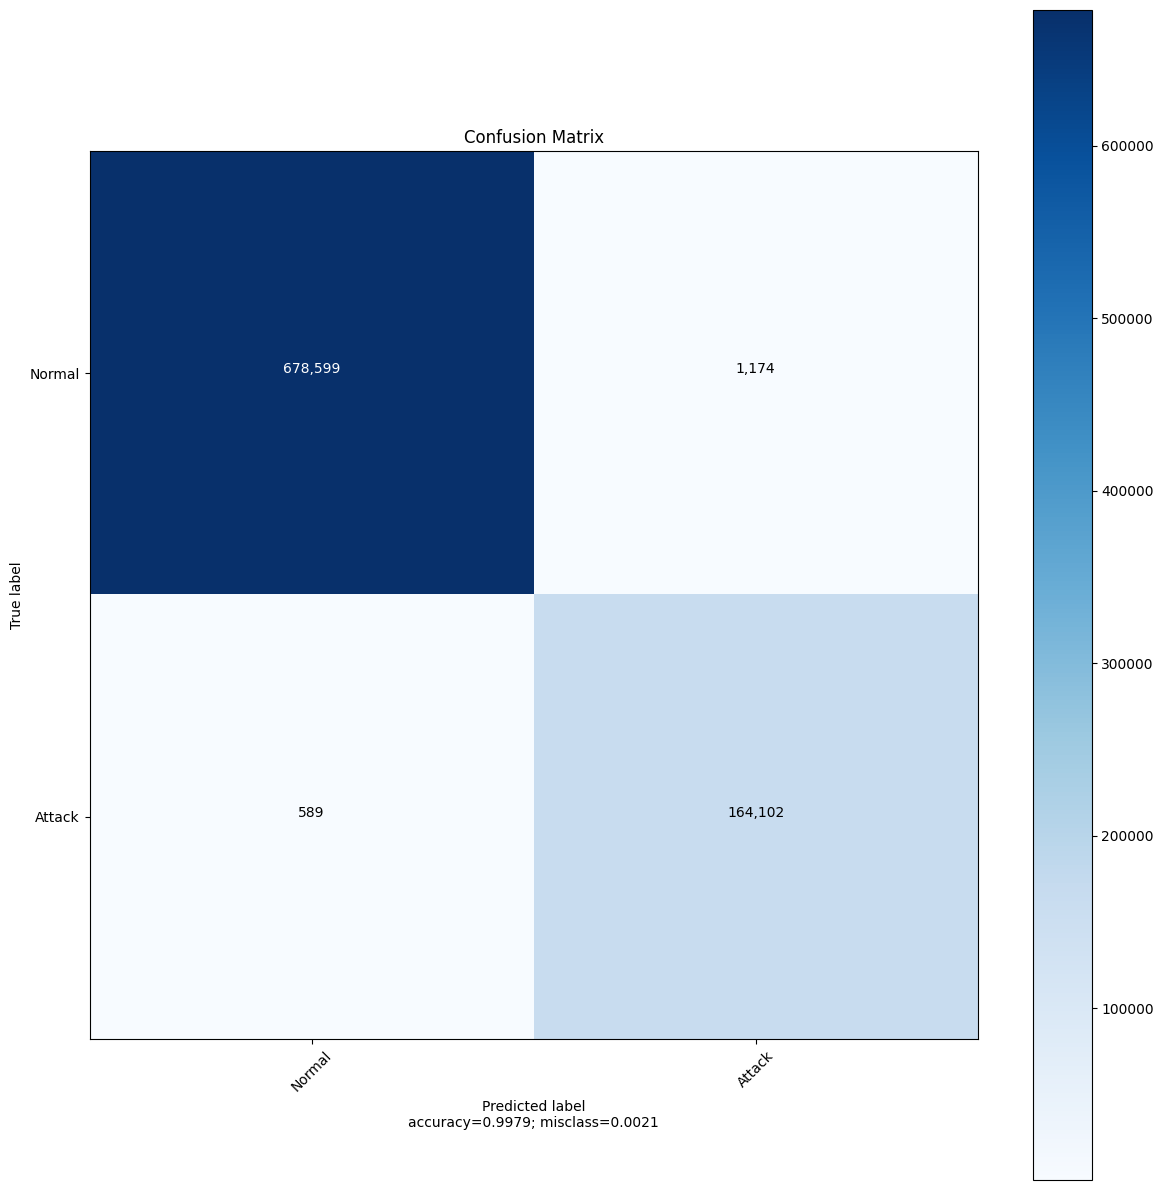

In [62]:
plot_confusion_matrix(cm = cm,
                      normalize    = False,
                      target_names = labels,
                      title        = "Confusion Matrix",
                      file_path = confusion_matrices_path + '/e_gcn.png')

In [63]:
FPR, FNR = calculate_FPR_FNR(cm)

In [64]:
cr = classification_report(actual, test_pred, digits=4, output_dict=True)
results_final["e_gcn"]["elapsed"] = elapsed
results_final["e_gcn"]["classification_report"] = cr
results_final["e_gcn"]["FPR"] = FPR
results_final["e_gcn"]["FNR"] = FNR
results_final["accuracy"]["e_gcn"] = cr["accuracy"]
results_final["time_elapsed"]["e_gcn"] = elapsed

print(classification_report(actual, test_pred, digits=4))

              precision    recall  f1-score   support

      Attack     0.9929    0.9964    0.9947    164691
      Normal     0.9991    0.9983    0.9987    679773

    accuracy                         0.9979    844464
   macro avg     0.9960    0.9973    0.9967    844464
weighted avg     0.9979    0.9979    0.9979    844464



### Testing EGCN residual

In [65]:
actual, test_pred, elapsed = test_gnn(model_gcn_res, G_test)

1.810240600258112 seconds


In [66]:
labels = ["Normal", "Attack"]
cm = confusion_matrix(actual, test_pred, labels= labels)

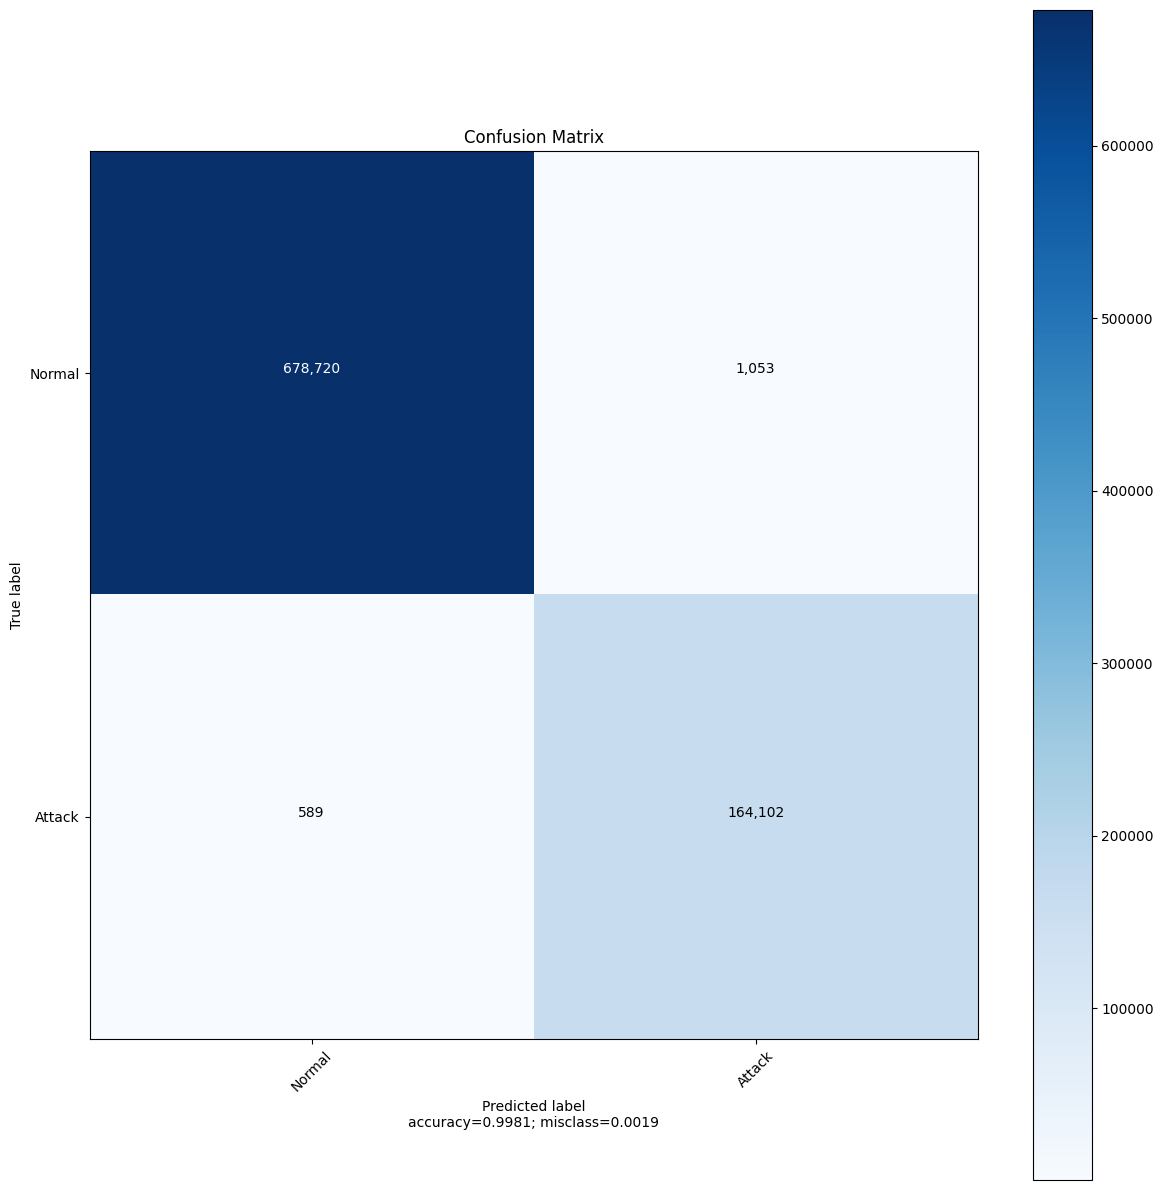

In [67]:
plot_confusion_matrix(cm = cm, 
                      normalize    = False,
                      target_names = labels,
                      title        = "Confusion Matrix",
                      file_path = confusion_matrices_path + '/e_gcn_res.png')

In [68]:
FPR, FNR = calculate_FPR_FNR(cm)

In [69]:
cr = classification_report(actual, test_pred, digits=4, output_dict=True)
results_final["e_gcn_res"]["elapsed"] = elapsed
results_final["e_gcn_res"]["classification_report"] = cr
results_final["e_gcn_res"]["FPR"] = FPR
results_final["e_gcn_res"]["FNR"] = FNR
results_final["accuracy"]["e_gcn_res"] = cr["accuracy"]
results_final["time_elapsed"]["e_gcn_res"] = elapsed

print(classification_report(actual, test_pred, digits=4))

              precision    recall  f1-score   support

      Attack     0.9936    0.9964    0.9950    164691
      Normal     0.9991    0.9985    0.9988    679773

    accuracy                         0.9981    844464
   macro avg     0.9964    0.9974    0.9969    844464
weighted avg     0.9981    0.9981    0.9981    844464



### Testing EGraphSage

In [70]:
actual, test_pred, elapsed = test_gnn(model_sage, G_test)

0.7480790000408888 seconds


In [71]:
labels = ["Normal", "Attack"]
cm = confusion_matrix(actual, test_pred, labels= labels)

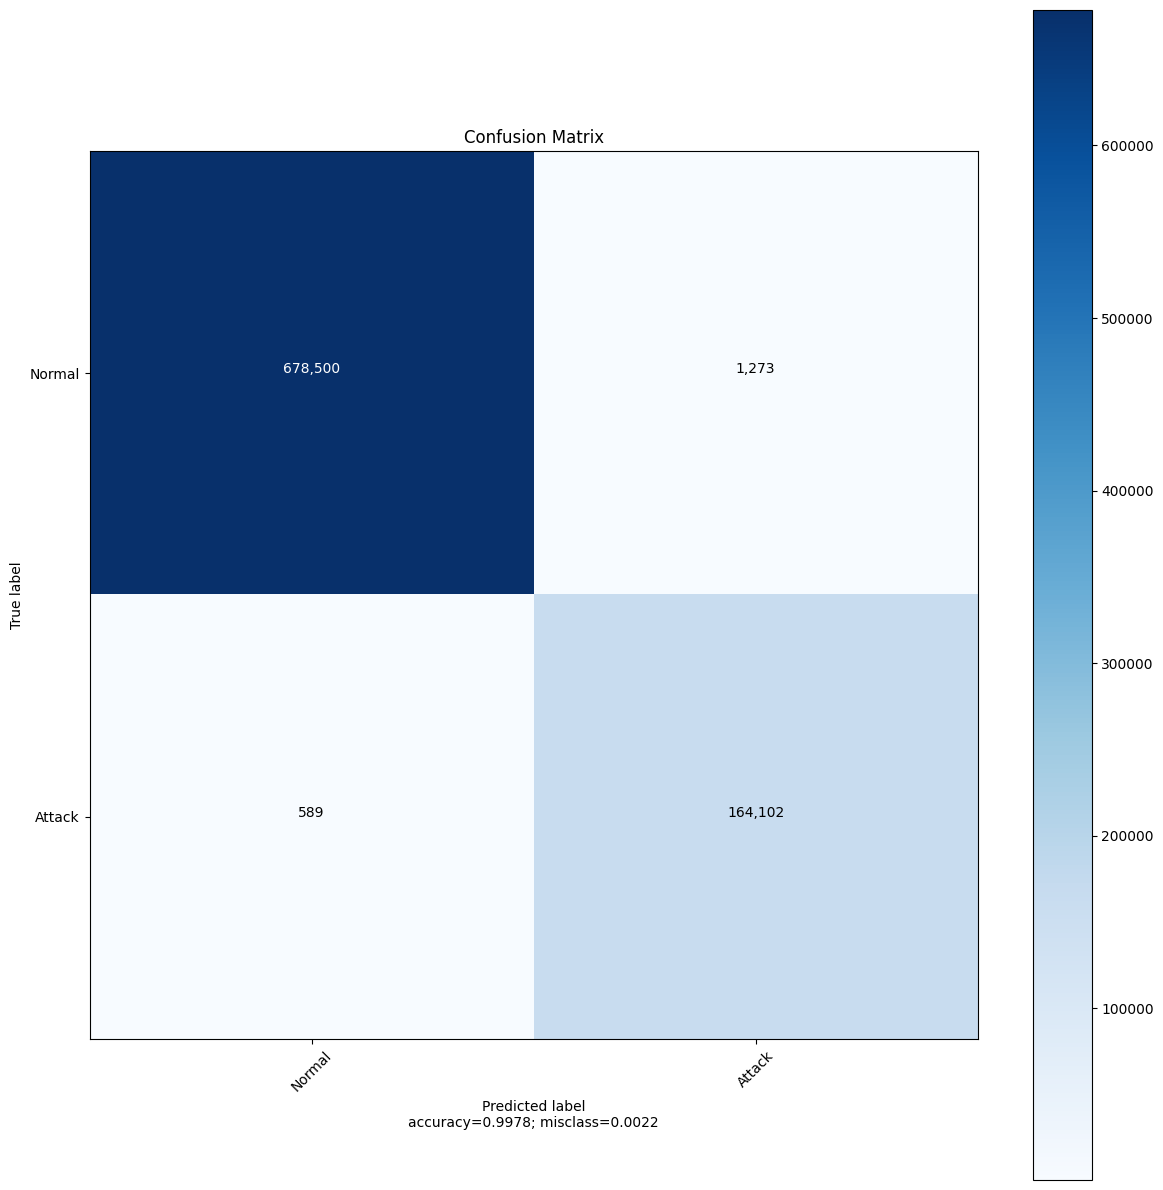

In [72]:
plot_confusion_matrix(cm = cm,
                      normalize    = False,
                      target_names = labels,
                      title        = "Confusion Matrix",
                      file_path = confusion_matrices_path + '/e_graph_sage.png')

In [73]:
FPR, FNR = calculate_FPR_FNR(cm)

In [74]:
cr = classification_report(actual, test_pred, digits=4, output_dict=True)
results_final["e_graph_sage"]["elapsed"] = elapsed
results_final["e_graph_sage"]["classification_report"] = cr
results_final["e_graph_sage"]["FPR"] = FPR
results_final["e_graph_sage"]["FNR"] = FNR
results_final["accuracy"]["e_graph_sage"] = cr["accuracy"]
results_final["time_elapsed"]["e_graph_sage"] = elapsed

print(classification_report(actual, test_pred, digits=4))

              precision    recall  f1-score   support

      Attack     0.9923    0.9964    0.9944    164691
      Normal     0.9991    0.9981    0.9986    679773

    accuracy                         0.9978    844464
   macro avg     0.9957    0.9973    0.9965    844464
weighted avg     0.9978    0.9978    0.9978    844464



### Testing EGraphSage residual

In [75]:
actual, test_pred, elapsed = test_gnn(model_sage_res, G_test)

1.192307399585843 seconds


In [76]:
labels = ["Normal", "Attack"]
cm = confusion_matrix(actual, test_pred, labels= labels)

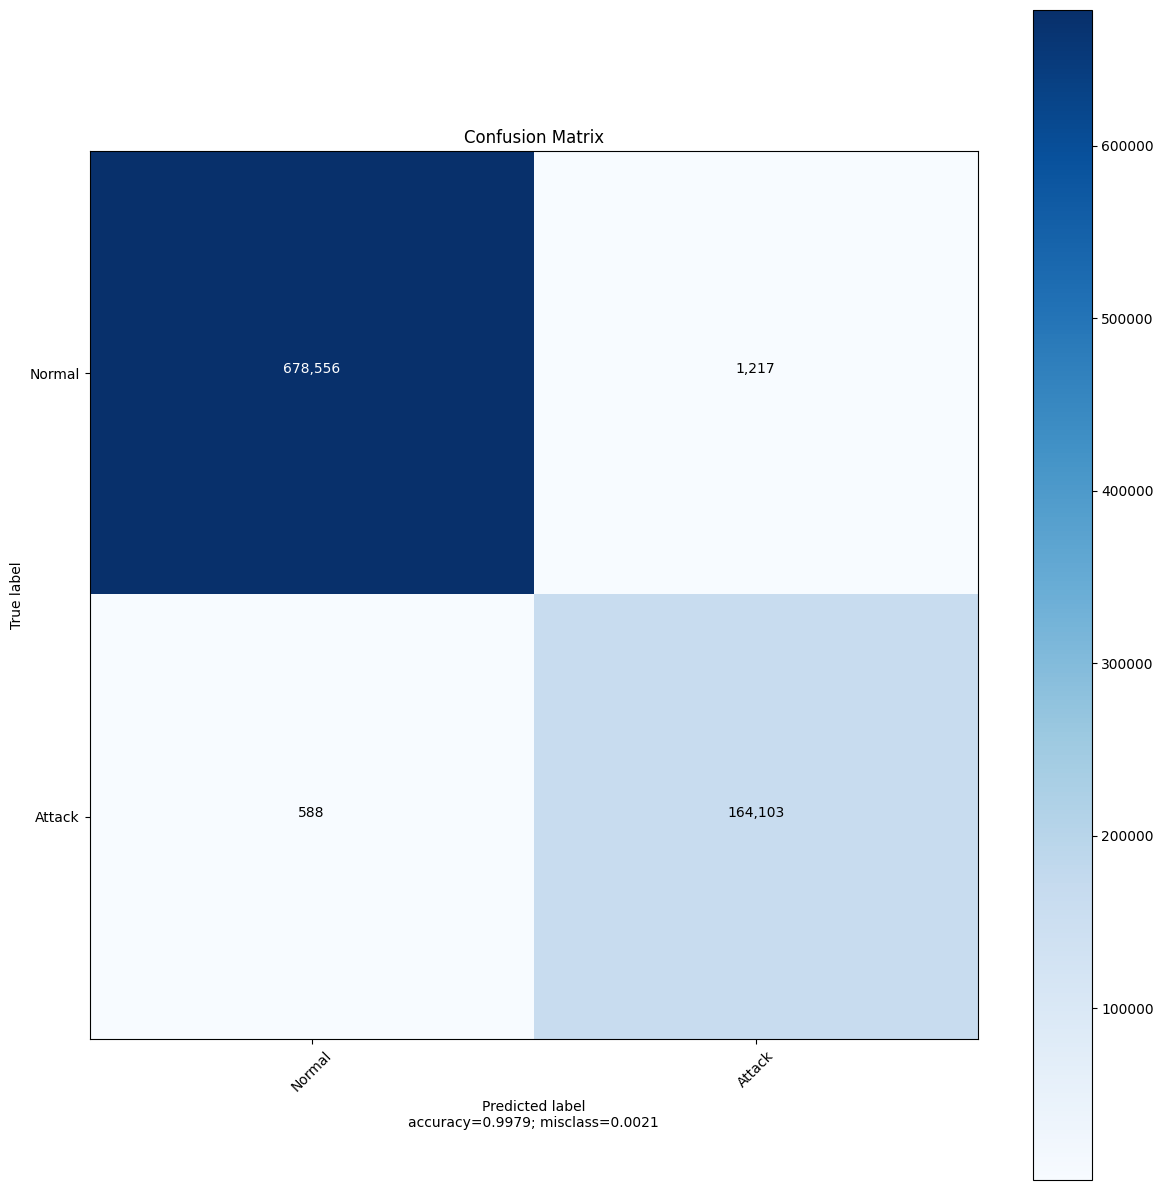

In [77]:
plot_confusion_matrix(cm = cm, 
                      normalize    = False,
                      target_names = labels,
                      title        = "Confusion Matrix",
                      file_path = confusion_matrices_path + '/e_graph_sage_res.png')

In [78]:
cr = classification_report(actual, test_pred, digits=4, output_dict=True)
results_final["e_graph_sage_res"]["elapsed"] = elapsed
results_final["e_graph_sage_res"]["classification_report"] = cr
results_final["e_graph_sage_res"]["FPR"] = FPR
results_final["e_graph_sage_res"]["FNR"] = FNR
results_final["accuracy"]["e_graph_sage_res"] = cr["accuracy"]
results_final["time_elapsed"]["e_graph_sage_res"] = elapsed

print(classification_report(actual, test_pred, digits=4))

              precision    recall  f1-score   support

      Attack     0.9926    0.9964    0.9945    164691
      Normal     0.9991    0.9982    0.9987    679773

    accuracy                         0.9979    844464
   macro avg     0.9959    0.9973    0.9966    844464
weighted avg     0.9979    0.9979    0.9979    844464



### Testing EGAT

In [79]:
actual, test_pred, elapsed = test_gnn(model_gat, G_test)

14.439422501251101 seconds


In [80]:
labels = ["Normal", "Attack"]
cm = confusion_matrix(actual, test_pred, labels= labels)

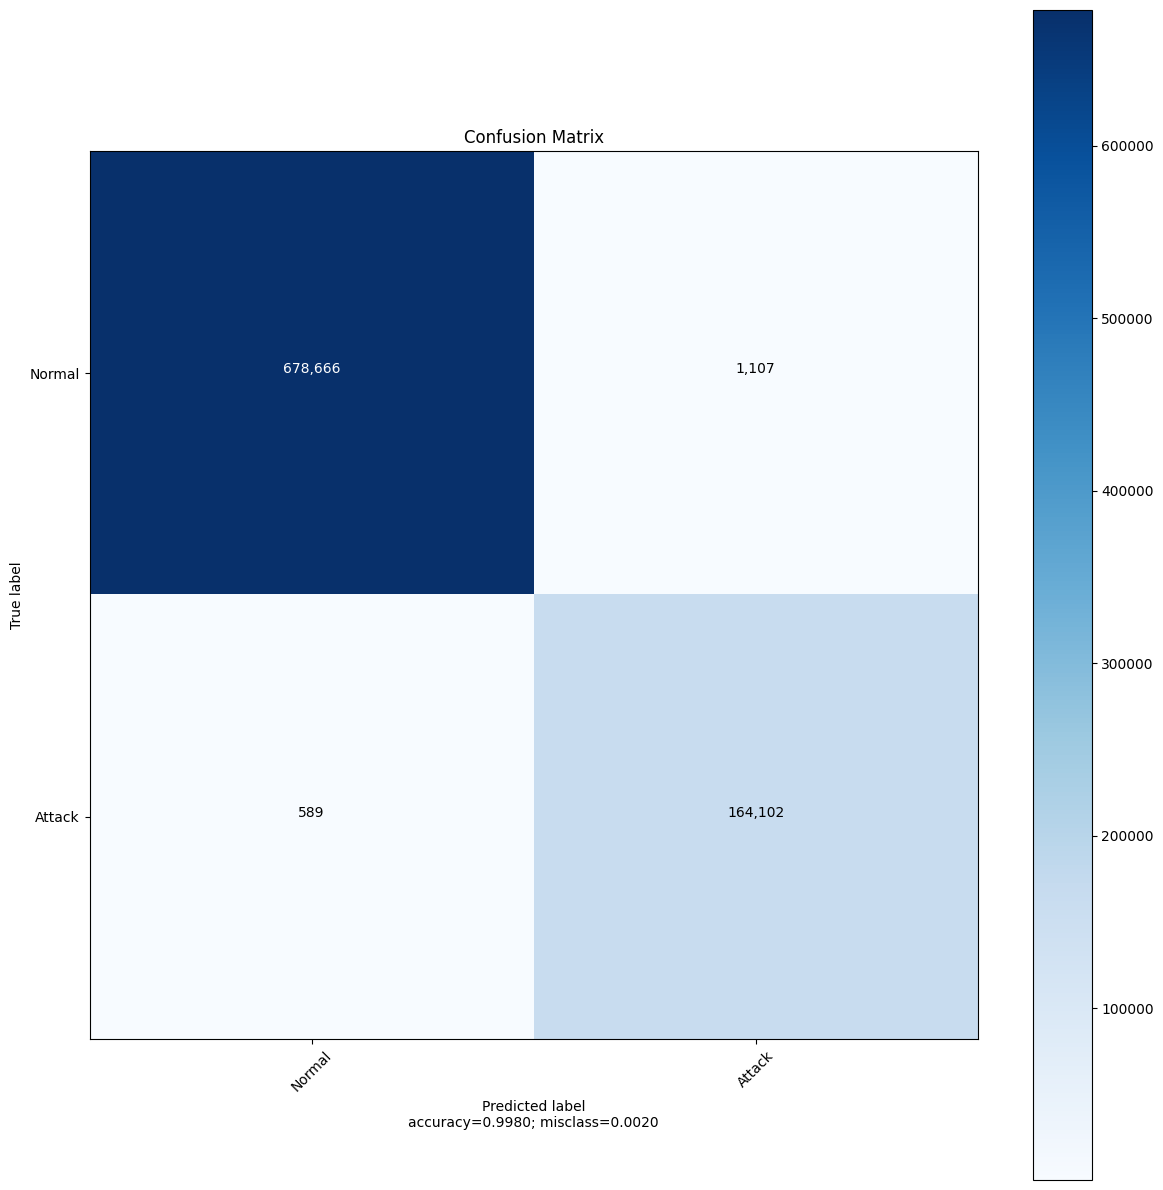

In [81]:
plot_confusion_matrix(cm = cm,
                      normalize    = False,
                      target_names = labels,
                      title        = "Confusion Matrix",
                      file_path = confusion_matrices_path + '/e_gat.png')

In [82]:
FPR, FNR = calculate_FPR_FNR(cm)

In [83]:
cr = classification_report(actual, test_pred, digits=4, output_dict=True)
results_final["e_gat"]["elapsed"] = elapsed
results_final["e_gat"]["classification_report"] = cr
results_final["e_gat"]["FPR"] = FPR
results_final["e_gat"]["FNR"] = FNR
results_final["accuracy"]["e_gat"] = cr["accuracy"]
results_final["time_elapsed"]["e_gat"] = elapsed

print(classification_report(actual, test_pred, digits=4))

              precision    recall  f1-score   support

      Attack     0.9933    0.9964    0.9949    164691
      Normal     0.9991    0.9984    0.9988    679773

    accuracy                         0.9980    844464
   macro avg     0.9962    0.9974    0.9968    844464
weighted avg     0.9980    0.9980    0.9980    844464



### Testing EGAT residual

In [84]:
actual, test_pred, elapsed = test_gnn(model_gat_res, G_test)

13.532751999795437 seconds


In [85]:
labels = ["Normal", "Attack"]
cm = confusion_matrix(actual, test_pred, labels= labels)

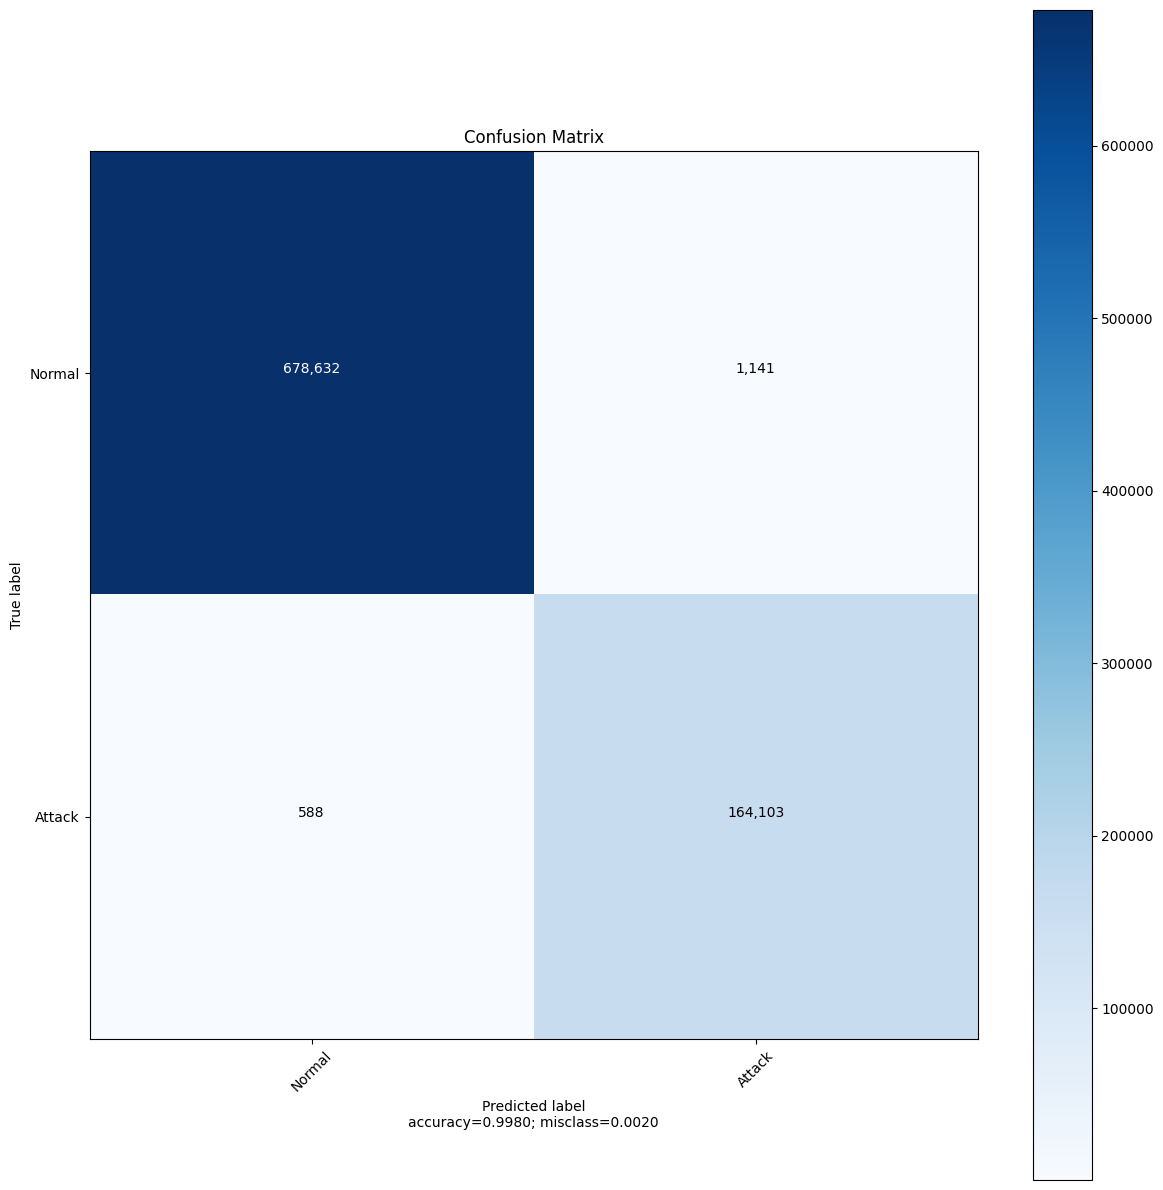

In [86]:
plot_confusion_matrix(cm = cm,
                      normalize    = False,
                      target_names = labels,
                      title        = "Confusion Matrix",
                      file_path = confusion_matrices_path + '/e_gat_res.png')

In [87]:
FPR, FNR = calculate_FPR_FNR(cm)

In [88]:
cr = classification_report(actual, test_pred, digits=4, output_dict=True)
results_final["e_gat_res"]["elapsed"] = elapsed
results_final["e_gat_res"]["classification_report"] = cr
results_final["e_gat_res"]["FPR"] = FPR
results_final["e_gat_res"]["FNR"] = FNR
results_final["accuracy"]["e_gat_res"] = cr["accuracy"]
results_final["time_elapsed"]["e_gat_res"] = elapsed

print(classification_report(actual, test_pred, digits=4))

              precision    recall  f1-score   support

      Attack     0.9931    0.9964    0.9948    164691
      Normal     0.9991    0.9983    0.9987    679773

    accuracy                         0.9980    844464
   macro avg     0.9961    0.9974    0.9967    844464
weighted avg     0.9980    0.9980    0.9980    844464



### Saving results

In [89]:
class NumpyEncoder(json.JSONEncoder):
    def default(self, obj):
        if isinstance(obj, np.integer):
            return int(obj)
        elif isinstance(obj, np.floating):
            return float(obj)
        elif isinstance(obj, np.ndarray):
            return obj.tolist()
        return super(NumpyEncoder, self).default(obj)

filename = (folder_path + '/results.json'.format(dtime))
outfile = open(filename, 'w')
outfile.writelines(json.dumps(results_final, cls=NumpyEncoder))
outfile.close()